<a href="https://colab.research.google.com/github/nandinib1999/edureka-assignments/blob/main/Edureka_Sequence_Learning_Assignment_4_Machine_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np 
import pandas as pd

import os
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re

import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

In [3]:
df=pd.read_csv("/content/drive/MyDrive/Hindi_English_Truncated_Corpus.csv",encoding='utf-8')

In [4]:
df['source'].value_counts()

tides        50000
ted          39881
indic2012    37726
Name: source, dtype: int64

In [5]:
df=df[df['source']=='ted']

In [6]:
df.head(20)

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
3,ted,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
7,ted,"And who are we to say, even, that they are wrong",और हम होते कौन हैं यह कहने भी वाले कि वे गलत हैं
13,ted,So there is some sort of justice,तो वहाँ न्याय है
23,ted,This changed slowly,धीरे धीरे ये सब बदला
26,ted,were being produced.,उत्पन्न नहीं कि जाती थी.
30,ted,"And you can see, this LED is going to glow.","और जैसा आप देख रहे है, ये एल.ई.डी. जल उठेगी।"
32,ted,to turn on the lights or to bring him a glass ...,"लाईट जलाने के लिए या उनके लिए पानी लाने के लिए,"
35,ted,Can you imagine saying that?,क्या आप ये कल्पना कर सकते है


In [7]:
df.isna().sum()

source              0
english_sentence    0
hindi_sentence      0
dtype: int64

In [8]:
df = df[~df.isna().any(axis=1)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39881 entries, 0 to 127606
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   source            39881 non-null  object
 1   english_sentence  39881 non-null  object
 2   hindi_sentence    39881 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [9]:
df.drop_duplicates(inplace=True)
df.shape

(38803, 3)

In [10]:
df=df.sample(n=25000,random_state=42)
df.shape

(25000, 3)

In [11]:
# Lowercase all characters
df['english_sentence']=df['english_sentence'].apply(lambda x: x.lower())
df['hindi_sentence']=df['hindi_sentence'].apply(lambda x: x.lower())

# Remove quotes
df['english_sentence']=df['english_sentence'].apply(lambda x: re.sub("'", '', x))
df['hindi_sentence']=df['hindi_sentence'].apply(lambda x: re.sub("'", '', x))

exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
df['english_sentence']=df['english_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
df['hindi_sentence']=df['hindi_sentence'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
df['english_sentence']=df['english_sentence'].apply(lambda x: x.translate(remove_digits))
df['hindi_sentence']=df['hindi_sentence'].apply(lambda x: x.translate(remove_digits))

df['hindi_sentence'] = df['hindi_sentence'].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))

# Remove extra spaces
df['english_sentence']=df['english_sentence'].apply(lambda x: x.strip())
df['hindi_sentence']=df['hindi_sentence'].apply(lambda x: x.strip())
df['english_sentence']=df['english_sentence'].apply(lambda x: re.sub(" +", " ", x))
df['hindi_sentence']=df['hindi_sentence'].apply(lambda x: re.sub(" +", " ", x))

In [12]:
# Add start and end tokens to target sequences
df['hindi_sentence'] = df['hindi_sentence'].apply(lambda x : 'START_ '+ x + ' _END')

In [13]:
df.isna().sum()

source              0
english_sentence    0
hindi_sentence      0
dtype: int64

In [14]:
df = df[~df.isna().any(axis=1)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 82040 to 91889
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   source            25000 non-null  object
 1   english_sentence  25000 non-null  object
 2   hindi_sentence    25000 non-null  object
dtypes: object(3)
memory usage: 781.2+ KB


In [15]:
df.head()

,source,english_sentence,hindi_sentence
82040,ted,we still dont know who her parents are who she is,START_ हम अभी तक नहीं जानते हैं कि उसके मातापि...
85038,ted,no keyboard,START_ कोई कुंजीपटल नहीं _END
58018,ted,but as far as being a performer,START_ लेकिन एक कलाकार होने के साथ _END
74470,ted,and this particular balloon,START_ और यह खास गुब्बारा _END
122330,ted,and its not as hard as you think integrate cli...,START_ और जितना आपको लगता है यह उतना कठिन नहीं...


In [16]:
eng_vocab = []
eng_sentences = df['english_sentence'].tolist()
eng_maxlen = 0
for sent in eng_sentences:
  words = sent.split(" ")
  words = [x.strip() for x in words if len(x.strip()) > 0]
  if eng_maxlen < len(words):
    eng_maxlen = len(words)
  eng_vocab.extend(words)


hindi_vocab = []
hindi_sentences = df['hindi_sentence'].tolist()
hindi_maxlen = 0
for sent in hindi_sentences:
  words = sent.split(" ")
  words = [x.strip() for x in words if len(x.strip()) > 0]
  if hindi_maxlen < len(words):
    hindi_maxlen = len(words)
  hindi_vocab.extend(words)


all_eng_words = list(set(eng_vocab))
all_hindi_words = list(set(hindi_vocab))

print("English Vocab:", len(all_eng_words))
print("Hindi Vocab:", len(all_hindi_words))

English Vocab: 14030
Hindi Vocab: 17540


In [17]:
len(all_eng_words)

14030

In [18]:
len(all_hindi_words)

17540

In [19]:
from collections import Counter

def word_count(vocabulary):
    ct = Counter(vocabulary)
    words = []
    cnt = []
    for i, j in ct.items():
      if i != "START_" and i != "_END":
        words.append(i)
        cnt.append(j)
    data = {"word":words , "count":cnt}
    df = pd.DataFrame(data)
    df = df.sort_values(by='count', ascending=False)
    df = df.reset_index()[["word","count"]]
    return df

In [20]:
word_cnt = word_count(eng_vocab)
word_cnt.head(20)

,word,count
0,the,9103
1,and,6268
2,to,5447
3,of,4968
4,a,4609
5,that,3560
6,in,3442
7,i,3059
8,is,2847
9,you,2813


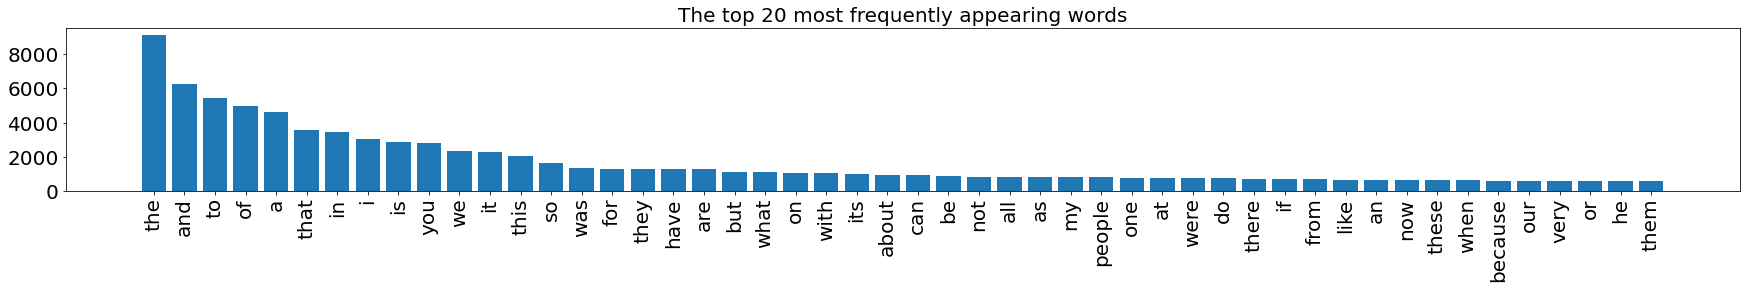

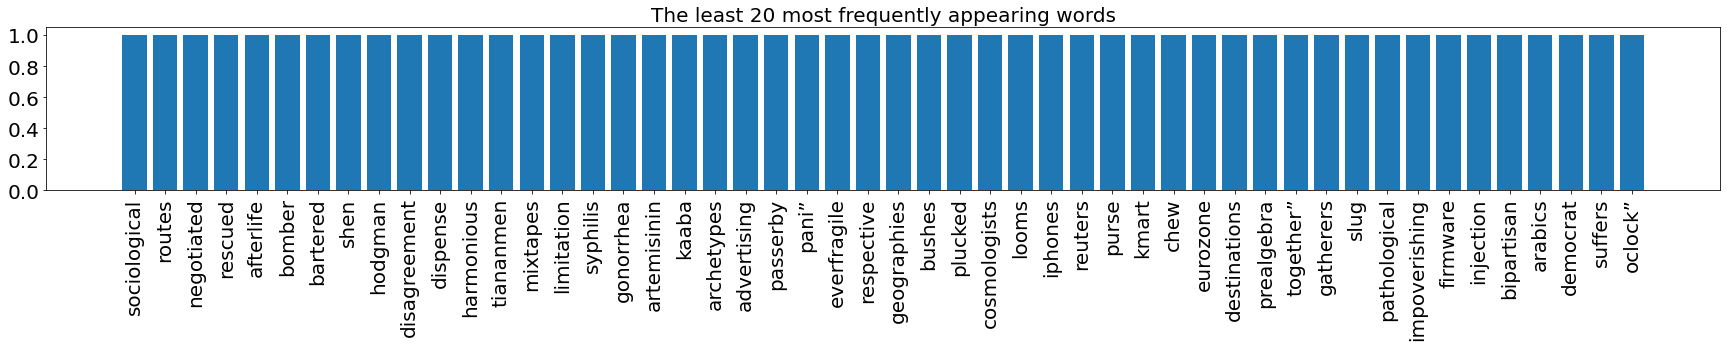

In [21]:
import matplotlib.pyplot as plt

topn = 50

def plot_word_count(df, title):
    plt.figure(figsize=(30,3))
    plt.bar(df.index, df["count"])
    plt.yticks(fontsize=20)
    plt.xticks(df.index,df["word"], rotation=90, fontsize=20)
    plt.title(title, fontsize=20)
    plt.show()

plot_word_count(word_cnt[:topn], title="The top 20 most frequently appearing words")
print()
plot_word_count(word_cnt[-topn:], title="The least 20 most frequently appearing words")

In [22]:
df['eng_sent_len'] = df['english_sentence'].apply(lambda x:len(x.split(" ")))
df['hindi_sent_len'] = df['hindi_sentence'].apply(lambda x:len(x.split(" ")))
df.head(20)

,source,english_sentence,hindi_sentence,eng_sent_len,hindi_sent_len
82040,ted,we still dont know who her parents are who she is,START_ हम अभी तक नहीं जानते हैं कि उसके मातापि...,11,16
85038,ted,no keyboard,START_ कोई कुंजीपटल नहीं _END,2,5
58018,ted,but as far as being a performer,START_ लेकिन एक कलाकार होने के साथ _END,7,8
74470,ted,and this particular balloon,START_ और यह खास गुब्बारा _END,4,6
122330,ted,and its not as hard as you think integrate cli...,START_ और जितना आपको लगता है यह उतना कठिन नहीं...,16,20
79517,ted,and saw the demo by jeff han,START_ और जेफ़ हान द्वारा प्रदर्शन देखा होगा _END,7,9
23089,ted,this baby is fully electric,START_ यह बच्चा पूरी तरह से बिजली से चलता है _END,5,11
116699,ted,kids have no or very little say in making the ...,START_ फिर भी बच्चों को नियम बनाने का बिलकुल न...,11,17
64132,ted,im going to add a little bit to my description...,START_ मै अपने द्वारा दिए गए उम्र के बढ़्ने के...,12,16
74513,ted,expands and cools until it gets to the point w...,START_ फैलने लगता है फिर ये ठंडा होकर उस अवस्थ...,13,21


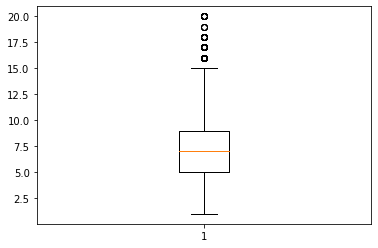

In [23]:
plt.boxplot(df['eng_sent_len'])
plt.show()

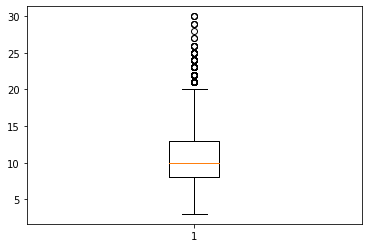

In [24]:
plt.boxplot(df['hindi_sent_len'])
plt.show()

In [25]:
df=df[df['eng_sent_len']<=20]
df=df[df['hindi_sent_len']<=20]

In [26]:
df.shape

(24774, 5)

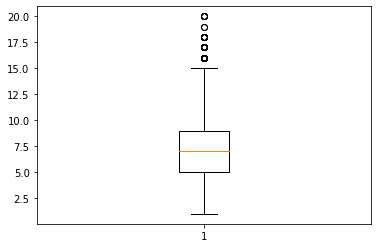

In [27]:
plt.boxplot(df['eng_sent_len'])
plt.show()

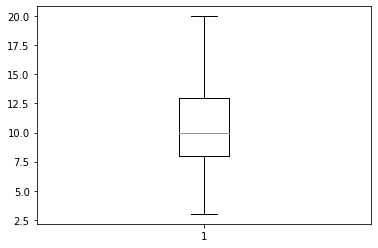

In [28]:
plt.boxplot(df['hindi_sent_len'])
plt.show()

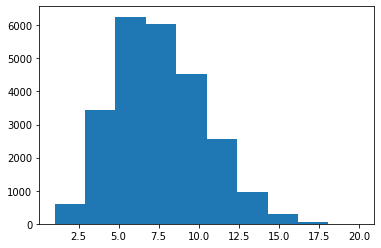

In [29]:
plt.hist(df['eng_sent_len'])
plt.show()

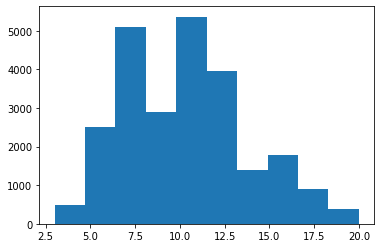

In [30]:
plt.hist(df['hindi_sent_len'])
plt.show()

In [31]:
max_length_src = max(df['hindi_sent_len'])
max_length_tar = max(df['eng_sent_len'])

print("Maximum length of Hindi Sentence:", max_length_src)
print("Maximum length of English Sentence:", max_length_tar)

Maximum length of Hindi Sentence: 20
Maximum length of English Sentence: 20


In [32]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_hindi_words))
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_hindi_words)
num_encoder_tokens, num_decoder_tokens

(14030, 17540)

In [33]:
num_decoder_tokens += 1
num_encoder_tokens += 1

In [34]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [35]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [36]:
df = shuffle(df)
df.head(10)

,source,english_sentence,hindi_sentence,eng_sent_len,hindi_sent_len
71318,ted,thats been viewed four million times,START_ और उसको भी चालीस लाख बार देखा गया है। _END,6,11
46829,ted,this herbavate cream for eczema possible,START_ हरबावेट क्रीम का निर्माण सँभव हुआ । _END,6,9
96392,ted,and thats a good thing because in order,START_ और यह अच्छी बात है क्योंकि _END,8,8
89048,ted,somalia had disintegrated into anarchy,START_ समालीया में आराजकता छा गयी थी _END,5,8
38443,ted,and asked me to define happiness,START_ और मुझसे ख़ुशी की परिभाषा पूछते _END,6,8
126860,ted,the insurgency thats been unleashed on your pe...,START_ ये आपके खिलाफ किया हुआ विद्रोह _END,8,8
69870,ted,making microdecisions dozens and dozens,START_ छोटे छोटे दर्ज़नों फ़ैसले लेने होते हैं...,5,9
110879,ted,on the banks of the rivers,START_ वैश्यावृत्ति में बदलकर रह गया है। _END,6,8
20352,ted,our heros are human heros,START_ मानव हीरो हमारा हीरो है _END,5,7
88219,ted,he had a side parting and a neat mustache,START_ उनके पास एक साइड पार्टिंग और एक साफ मूं...,9,12


In [37]:
X, y = df['english_sentence'], df['hindi_sentence']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=42)
X_train.shape, X_test.shape

((19819,), (4955,))

In [38]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

### Encoder-Decoder Architecture

In [39]:
latent_dim=300

In [40]:
# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [41]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True)
dec_emb = dec_emb_layer(decoder_inputs)
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [42]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

In [43]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    4209300     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 300)    5262300     input_2[0][0]                    
______________________________________________________________________________________________

In [44]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 128
epochs = 50

In [45]:
history = model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
154/154 [==============================] - 57s 209ms/step - loss: 3.2088 - val_loss: 2.8643
Epoch 2/50
154/154 [==============================] - 30s 192ms/step - loss: 2.7583 - val_loss: 2.6874
Epoch 3/50
154/154 [==============================] - 29s 189ms/step - loss: 2.5803 - val_loss: 2.6119
Epoch 4/50
154/154 [==============================] - 30s 194ms/step - loss: 2.4631 - val_loss: 2.5657
Epoch 5/50
154/154 [==============================] - 30s 195ms/step - loss: 2.3769 - val_loss: 2.5434
Epoch 6/50
154/154 [==============================] - 30s 193ms/step - loss: 2.2923 - val_loss: 2.4941
Epoch 7/50
154/154 [==============================] - 30s 194ms/step - loss: 2.2164 - val_loss: 2.4787
Epoch 8/50
154/154 [==============================] - 30s 193ms/step - loss: 2.1484 - val_loss: 2.4698
Epoch 9/50
154/154 [==============================] - 30s 193ms/step - loss: 2.0791 - val_loss: 2.4502
Epoch 10/50
154/154 [==============================] - 29s 191ms/step - l

In [46]:
model.save_weights('nmt_weights.h5')

In [47]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)


In [48]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [49]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [50]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

Input English sentence: and of intelligence
Actual Hindi Translation:  और बुद्धिमत्ता को 
Predicted Hindi Translation:  और बुद्धिमत्ता को 


In [51]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

Input English sentence: i would have died in a day
Actual Hindi Translation:  तो मैं वहां एक दिन में मर गया होता 
Predicted Hindi Translation:  तो मैं एक दिन में काम करना चाहता था 


In [52]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

Input English sentence: and people started renovating their own structures
Actual Hindi Translation:  और लोगों ने अपने ही ढ़ाँचे को पुनः बनाना शुरु किया। 
Predicted Hindi Translation:  और लोग अपने घर का जन्म क्षेत्र में था 


In [53]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

Input English sentence: bullets from bursting
Actual Hindi Translation:  गोलियां फोड़ना बंद नहीं करता है 
Predicted Hindi Translation:  नहीं जाएगा 


In [54]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Hindi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Hindi Translation:', decoded_sentence[:-4])

Input English sentence: and so its not just an offshore problem
Actual Hindi Translation:  तो यह केवल देश के बाहर की समस्या नहीं है 
Predicted Hindi Translation:  और यह तो किसी के लिए ये मुमकिन नहीं है । 
